# Spatial Join

Combining information between data layers.

Options: 
- Spatial predicates determine the relationship
  - `within`
  - `intersects` (default)
  - `contains`
  - `covered_by`
  - `crosses`
  - `overlaps`
  - `touches`
  - etc.
- Join type to determine what data is selected
  - inner (default)
  - left outer
  - right outer

![](images/spatial-join1.png)

![](images/spatial-join2.png)

# Spatial join in Python

Join geocoded addresses with a population grid

In [2]:
import geopandas as gpd 

addr_fp = "data/ch6/Helsinki/addresses.shp"
addresses = gpd.read_file(addr_fp)
print(addresses.head(2))

                                             address    id  \
0  Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...  1000   
1  Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...  1001   

                                       addr                   geometry  
0  Itämerenkatu 14, 00101 Helsinki, Finland   POINT (24.91556 60.1632)  
1     Kampinkuja 1, 00100 Helsinki, Finland  POINT (24.93166 60.16905)  


In [3]:
pop_grid_fp = "data/ch6/Helsinki/Population_grid_2021_HSY.gpkg"
pop_grid = gpd.read_file(pop_grid_fp)
print(pop_grid.head(2))

                           id  inhabitants  occupancy_rate  \
0  Vaestotietoruudukko_2021.1            5           50.60   
1  Vaestotietoruudukko_2021.2            7           36.71   

                                            geometry  
0  POLYGON ((25472499.995 6689749.005, 25472499.9...  
1  POLYGON ((25472499.995 6685998.998, 25472499.9...  


In [4]:
pop_grid.shape

(5853, 4)

## Prepare for the join

- Ensure idential CRS
- Visualize the data

In [5]:
print(f"{addresses.crs.name=}")
print(f"{pop_grid.crs.name=}")

addresses.crs.name='WGS 84'
pop_grid.crs.name='ETRS89 / GK25FIN'


In [6]:
addresses.crs == pop_grid.crs

False

> Reproject

In [7]:
addresses = addresses.to_crs(crs=pop_grid.crs)
addresses.crs == pop_grid.crs

True

> Visualize

How are the inhabitants distributed over the region? Do the addresses intersect with the grid?

In [8]:
print(pop_grid.columns)

Index(['id', 'inhabitants', 'occupancy_rate', 'geometry'], dtype='object')


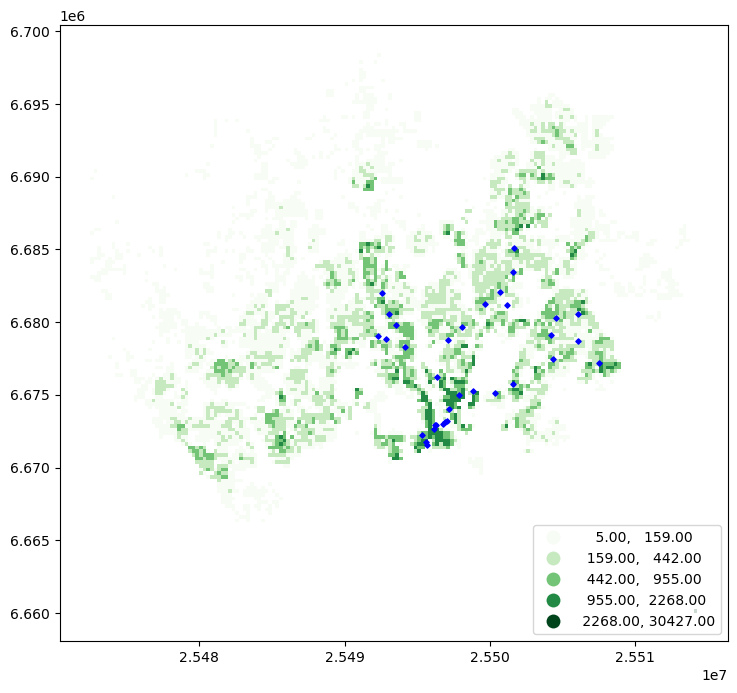

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt 

ax = pop_grid.plot(
    column = "inhabitants", 
    cmap = "Greens", 
    scheme="naturalbreaks", 
    k=5, 
    legend=True, 
    legend_kwds={"loc": "lower right"}, 
    figsize=(10,8)
)

ax = addresses.plot(ax=ax, color="blue", markersize=7, marker="D");

# Join the layers

In [10]:
join = addresses.sjoin(
    pop_grid, 
    predicate="within", 
    how="inner"
)
print(join.head(2))
print(f"{join.columns=}")
print(f"{join.shape=}")

                                             address  id_left  \
0  Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...     1000   
1  Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...     1001   

                                       addr                          geometry  \
0  Itämerenkatu 14, 00101 Helsinki, Finland  POINT (25495311.608 6672258.695)   
1     Kampinkuja 1, 00100 Helsinki, Finland  POINT (25496206.216 6672909.016)   

   index_right                       id_right  inhabitants  occupancy_rate  
0         3262  Vaestotietoruudukko_2021.3263          505           14.01  
1         3381  Vaestotietoruudukko_2021.3382          172           27.67  
join.columns=Index(['address', 'id_left', 'addr', 'geometry', 'index_right', 'id_right',
       'inhabitants', 'occupancy_rate'],
      dtype='object')
join.shape=(31, 8)


In [11]:
print(join.head(2))

                                             address  id_left  \
0  Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...     1000   
1  Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...     1001   

                                       addr                          geometry  \
0  Itämerenkatu 14, 00101 Helsinki, Finland  POINT (25495311.608 6672258.695)   
1     Kampinkuja 1, 00100 Helsinki, Finland  POINT (25496206.216 6672909.016)   

   index_right                       id_right  inhabitants  occupancy_rate  
0         3262  Vaestotietoruudukko_2021.3263          505           14.01  
1         3381  Vaestotietoruudukko_2021.3382          172           27.67  


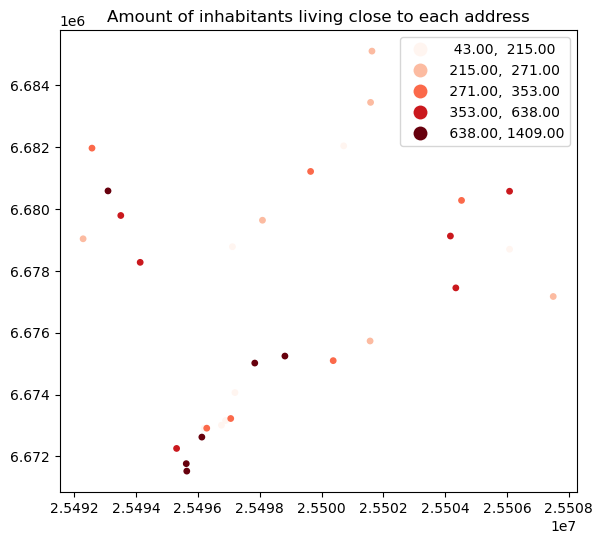

In [12]:
ax = join.plot(
    column="inhabitants", 
    cmap="Reds", 
    markersize=15, 
    scheme="quantiles", 
    legend=True, 
    figsize=(10,6)
)
ax.set_title("Amount of inhabitants living close to each address");

> Check for lost data

In [13]:
len(addresses) - len(join)

3

> This interactive map will not show in my notes

In [14]:
#m = pop_grid.explore(
#    color="blue", 
#    style_kwds=dict(color="blue", stroke=False)
#)
#addresses.explore(m=m, color="red")

Some points are outside of polygons.

In [15]:
import pandas as pd 
pd.set_option("display.max_rows", 7)

In [16]:
left_join = addresses.sjoin(pop_grid, predicate="within", how="left")
print(left_join.head(6))

                                             address  id_left  \
0  Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...     1000   
1  Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...     1001   
2  Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...     1002   
3  Hermannin rantatie, Verkkosaari, Kalasatama, S...     1003   
4  9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...     1005   
5  18, Kontulantie, Kontula, Mellunkylä, Itäinen ...     1006   

                                            addr  \
0       Itämerenkatu 14, 00101 Helsinki, Finland   
1          Kampinkuja 1, 00100 Helsinki, Finland   
2           Kaivokatu 8, 00101 Helsinki, Finland   
3  Hermannin rantatie 1, 00580 Helsinki, Finland   
4     Tyynenmerenkatu 9, 00220 Helsinki, Finland   
5        Kontulantie 18, 00940 Helsinki, Finland   

                           geometry  index_right  \
0  POINT (25495311.608 6672258.695)       3262.0   
1  POINT (25496206.216 6672909.016)       3381.0   
2  POINT (25496762.723 

In [17]:
left_join.shape

(34, 8)

> Which addresses aren't in the polygons?

In [18]:
print(left_join.loc[left_join["inhabitants"].isnull()])

                                              address  id_left  \
9   Sodexo, 5, Atomitie, Strömberg, Pitäjänmäen te...     1010   
18  6, Ratapihantie, Itä-Pasila, Pasila, Keskinen ...     1019   
21  Tattariharjuntie, Ala-Malmi, Malmi, Koillinen ...     1022   

                                         addr  \
9         Atomitie 5, 00370 Helsinki, Finland   
18    Ratapihantie 6, 00101 Helsinki, Finland   
21  Tattariharjuntie, 00700 Helsinki, Finland   

                            geometry  index_right id_right  inhabitants  \
9   POINT (25492851.783 6678869.234)          NaN      NaN          NaN   
18     POINT (25496358.8 6676198.28)          NaN      NaN          NaN   
21  POINT (25501142.787 6681208.443)          NaN      NaN          NaN   

    occupancy_rate  
9              NaN  
18             NaN  
21             NaN  
